# New Plan

1. Split data into 4 seasons - process NOAA and CAISO data together.ipynb
2. Select a month in the season - I choose august bc no holidays hehe
3. Split season into weekdays and weekends/holidays
4. Output prediction for the whole season
5. Check it against the results from CAISO 

**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



In [30]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [31]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [32]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [33]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer

def prepareDf(df, cols_rearranged, baseLSTM_Directory, location, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = 30 * 60 * day #num seconds in a month of JUNE
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  
  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [34]:
#purpose: selecting the best energy consumption model 
#input: iters = num iterations to find best model, df = dataframe, numEpochs = number of epochs for training model, baseLSTM_Directory = LSTM directory, location = place sf/sd/sac/etc.
#output: return a list of the best performing model for each weather var

def getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]

In [35]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption

def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    beg = 1 #
    end = window_size # first prediction starts from h1 -> h24
    newHour = window_size # the first predicted value
    while(i<howManyFutureHours): #for the next thirty hours
        if i == 0: #for the first new predicted value, using old weather data to predict new value 
            x_input = np.array(dataForPrediction.iloc[i:window_size, :])
            # print('x_input: ', x_input)
            x_input = x_input.reshape(1, window_size, numVarInputs)
            yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
            print(yhat[0])
            future_outputs.append(yhat[0][0])
            i=i+1
        else:# predicting new values
            # get past 23 hours data 
            past23Hours = dataForPrediction.iloc[beg:end,:]
            # print(future_outputs[newHour])
            predictedEnergy = future_outputs[i-1].item()
            dataForPrediction.at[newHour, -1:] = predictedEnergy #set the megawatts val from the prev predicted
            newHourData = dataForPrediction.iloc[newHour:newHour+1, :]
            newHourData = pd.concat([past23Hours, newHourData])
            oneData = np.array(newHourData)
            # print("{} hour input {}".format(1, oneData))
            oneData = oneData.reshape((1, window_size, numVarInputs)) #works
            yhat = bestEnergyConsumptionModel.predict(oneData, verbose=0)
            # print("{} hour output {}".format(i,yhat))
            future_outputs.append(yhat[0][0])
            i=i+1
            newHour+=1

    return future_outputs

In [36]:
def oneMonthRepresentation_june():
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/june/' 

  dates2019 = [ '20190601', '20190602','20190603','20190604','20190605','20190606','20190607','20190608','20190609','20190610',
              '20190611','20190612','20190613','20190614','20190615','20190616','20190617','20190618','20190619','20190620','20190621',
              '20190622','20190623','20190624','20190625','20190626','20190627','20190628','20190629','20190630']
  dates2020 = ['20200601','20200602','20200603','20200604','20200605','20200606','20200607','20200608','20200609','20200610',
              '20200611','20200612','20200613','20200614','20200615','20200616','20200617','20200618','20200619','20200620','20200621',
              '20200622','20200623','20200624','20200625','20200626','20200627','20200628','20200629','20200630','20200631']
  dates2021 = ['20210601','20210602','20210603','20210604','20210605','20210606','20210607','20210608','20210609','20210610','20210611',
              '20210612','20210613','20210614','20210615','20210616','20210617','20210618','20210619','20210620','20210621','20210622',
              '20210623','20210624','20210625','20210626','20210627','20210628','20210629','20210630']
  june = ['06-01','06-02','06-03','06-04','06-05','06-06','06-07','06-08','06-09','06-10','06-11','06-12','06-13','06-14','06-15','06-16','06-17',
          '06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28','06-29','06-30']

  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  result2019 = pd.DataFrame()
  result2020 = pd.DataFrame()
  result2021 = pd.DataFrame()
  for i in range(len(dates2019)):
    #2019
    read2019 = pathToData + beg + dates2019[i] + end
    df2019 = pd.read_csv(read2019)
    df2019.drop('date', axis=1, inplace=True)
    result2019 = pd.concat([result2019, df2019], axis=1)
    result2019.iloc[:1, :]
    result2019['mean'] = result2019.mean(axis=1)

    #2020
    read2020 = pathToData + beg + dates2020[i] + end
    df2020 = pd.read_csv(read2020)
    df2020.drop('date', axis=1, inplace=True)
    result2020 = pd.concat([result2020, df2020], axis=1)
    result2020.iloc[:1, :]
    result2020['mean'] = result2020.mean(axis=1)
    #2021
    read2021 = pathToData + beg + dates2021[i] + end
    df2021 = pd.read_csv(read2021)
    df2021.drop('date', axis=1, inplace=True)
    result2021 = pd.concat([result2021, df2021], axis=1)
    result2021.iloc[:1, :]
    result2021['mean'] = result2021.mean(axis=1)

  plt.plot(result2019['mean'], color = 'blue', label = '2019')
  plt.plot(result2020['mean'], color = 'red', label = '2020')
  plt.plot(result2021['mean'], color = 'green', label = '2021')

  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  plt.suptitle('June')
  plt.legend()
  plt.savefig(pathToSaveData+ 'juneAvg.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()

  rms2019_2020 = mean_squared_error(result2019['mean'], result2020['mean'], squared=False)
  rms2019_2021 = mean_squared_error(result2019['mean'], result2021['mean'], squared=False)
  rms2020_2021 = mean_squared_error(result2020['mean'], result2021['mean'], squared=False)
  avg3 = (rms2019_2020 + rms2019_2021 + rms2020_2021)/3
  print('Average RMSE between 2019-2020, 2019-2021, 2020-2021: ', avg3)
  averageJune= pd.concat([result2019['mean'], result2020['mean'], result2021['mean']], axis=1)
  finalRep = averageJune.mean(axis=1)
  return finalRep

In [202]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size) 
    #############################################train and test #########################################################
    train_percent = 0.90
    validation_percent = 0.1

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation
    # X_train.shape, y_train.shape, X_val.shape, y_val.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(64, 'relu')) #hidden layer 1
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.001), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

# Run

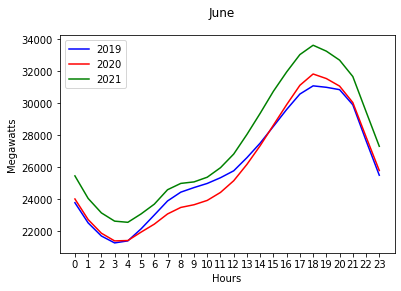

Average RMSE between 2019-2020, 2019-2021, 2020-2021:  1244.4072646780573


In [203]:
juneRep = oneMonthRepresentation_june()

In [204]:
# juneRep

In [207]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/Years_Average/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

fileRead = pathToData + dataFile[0]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
dfOriginal = pd.read_csv(fileRead)

howManyFutureHours = 24
window_size = 48
numEpochs = 30
iters = 1
### month of june
beg = 3624
end = 4344

baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/'
location = '_SAC'
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL
# bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, cols_rearranged, columns, df, currentDirectory, location)


SAC-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/Years_Average/SAC-yearAvg-NOAA-and-Megawatts.csv


431
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0764 - root_mean_squared_error: 0.2764

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 8s 480ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.1448

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 5s 425ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 3/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 4/30
13/13 [==============================] - 1s 45ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 5/30
13/13 [==============================] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0819

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 5s 432ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 6/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 7/30
13/13 [==============================] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0633

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 5s 437ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 8/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 9/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 10/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 11/30
13/13 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 5s 396ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 8.8118e-04 - val_root_mean_squared_error: 0.0297
Epoch 12/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 13/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 14/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 15/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 9.0426e-04 - val_root_mean_squared_error: 0.0301
Epoch 16/30
13/13 [==============================] - 1s 44ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0030 - val_roo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


13/13 [==============================] - 5s 441ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 6.6179e-04 - val_root_mean_squared_error: 0.0257
Epoch 18/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 19/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 20/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 21/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 22/30
13/13 [==============================] - 1s 45ms/step - loss: 9.4340e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0038 - val_roo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_SAC/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_SAC/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


[0.31045985]
----------------------------FINAL, DONE;----------------------------
rmse value:  3137.2099528039075


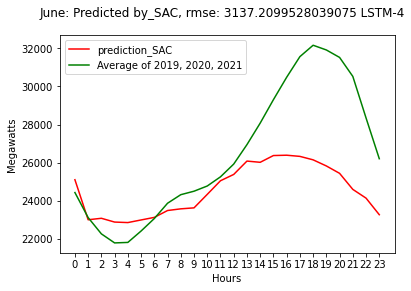

In [208]:
df.columns[1:-1]
cols_rearranged = list(df.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('AvgMegawatts2019-2020-2021')

df = prepareDf(df, cols_rearranged, baseLSTM_Directory, location, beg, end)
df = df[df.is_weekend == 0] # only keeping weekday data
df.drop('is_weekend', axis = 1, inplace =True)
df, allScalers = scaleAllData(df)
# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers

bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")

########################################## GET WEATHER DATA FOR FUTURE PREDICTION #######################################################
lastDay_input = df.iloc[len(df) - (window_size*2):(len(df) - window_size),:] # second to last day

# # ########################################## FUTURE PREDICTION #######################################################

numVarInputs = len(lastDay_input.columns)

# print('num var inputs: ', numVarInputs)
# I need ground truth weather data 
weatherData = df.iloc[len(df)- (window_size):, :-1] 
weatherData['AvgMegawatts2019-2020-2021'] = 0 #24->47 is for "future" day; exclude megawatts data

dataForPrediction = pd.concat([lastDay_input, weatherData])

lst_output = futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs)

# # ########################################### check output #######################################################
# scaler_filename = baseLSTM_Directory + 'Best'+ location+ '/Scalers' + location+'/AvgMegawatts2019-2020-2021.save'

# megawattsScaler = joblib.load(scaler_filename)
megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
predicted24Hours = pd.DataFrame(predictedVals)

print("----------------------------FINAL, DONE;----------------------------")
rmse = mean_squared_error(juneRep, predicted24Hours, squared=False)
print('rmse value: ', rmse)

plt.plot(predicted24Hours, color = 'red', label = 'prediction'+location)
plt.plot(juneRep, color = 'green', label = 'Average of 2019, 2020, 2021')
xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('June: Predicted by'+location+', rmse: ' + str(rmse) +' LSTM-4')
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/byMonth_LSTM/'
plt.savefig(pathToSaveData+ 'JuneAvg'+location+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


In [ ]:
# June, SAC, LSTM-Basic:
# 3365.0527538185884 
# 2709.5685428139836
# 2682.176218725889
# LSTM-1 is BAD:
# model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
# model.add(Dense(32, 'relu')) #hidden layer 1
# model.add(Dense(1, 'linear')) #output layer
# 3047.106441143009
# 3279.308643887853
# 2931.9482840644505
#LSTM-2:
# model.add(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
# model.add(Dense(32, 'relu')) #hidden layer 1
# model.add(Dense(32, 'relu')) #hidden layer 1
# model.add(Dense(1, 'linear')) #output layer
# 2614.353682862183
# 3275.0059424474907
# 2728.6914050742903
#LSTM-3:
# model.add(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
# model.add(Dense(64, 'relu')) #hidden layer 1
# model.add(Dense(32, 'relu')) #hidden layer 1
# model.add(Dense(1, 'linear')) #output layer
# 2855.5003686848095
# 2966.7474960557192
# 3425.6539014270707
#LSTM-4:
# model.add(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
# model.add(Dense(64, 'relu')) #hidden layer 1
# model.add(Dense(1, 'linear')) #output layer
# 2613.3168277215836
# 2734.576641118105
# 3143.187063066916
#LSTM-5:
# model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]))) #100 steps, 1 feature 
# model.add(Dense(1, 'linear')) #output layer
# 3259.147332496291
# 3078.1125806134805
# 3877.9240904623875

In [132]:
from statistics import mean

avg1 = mean([3365.0527538185884, 2709.5685428139836 , 2682.176218725889])
avg2 = mean([3047.106441143009, 3279.308643887853, 2931.9482840644505])
avg3 = mean([2614.353682862183, 3275.0059424474907, 2728.6914050742903])
avg4 = mean([2855.5003686848095, 2966.7474960557192, 3425.6539014270707])
avg5 = mean([2613.3168277215836, 2734.576641118105, 3143.187063066916])
avg6 = mean([3259.147332496291, 3078.1125806134805, 3877.9240904623875])
print('lstm-basic: ', str(avg1))
print('lstm-1: ', str(avg2))
print('lstm-2: ', str(avg3))
print('lstm-3: ', str(avg4))
print('lstm-4: ', str(avg5))
print('lstm-5: ', str(avg6))

lstm-basic:  2918.932505119487
lstm-1:  3086.121123031771
lstm-2:  2872.6836767946547
lstm-3:  3082.6339220558666
lstm-4:  2830.3601773022015
lstm-5:  3405.061334524053


In [ ]:
# predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
# predicted24Hours = pd.DataFrame(predictedVals)
# predicted24Hours
#278873, 24722

In [ ]:
# dfOriginal

In [ ]:
# res = megawattsScaler.fit_transform(np.array(dfOriginal['AvgMegawatts2019-2020-2021'].values.reshape(-1, 1)))
# predictedVals = megawattsScaler.inverse_transform(np.array(res).reshape(-1,1))
# predictedVals

In [ ]:
# df